# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\SABEENA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\SABEENA\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
#Sampling 100K points 
final=final.groupby('Score').apply(lambda x: x.sample(50000))#sampling equal number of points from each class
final['Score'].value_counts()

1    50000
0    50000
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I do not reccommend this product...Moths flew right by it,,,an kept going. Other types bait traps have worked in the same area. Dee
I've tried this a couple of time and both times the noodle just fell apart.  The taste was rather sweet, not like regular pasta.  Now searching for some better pasta substitute.
I've finished this canister of tea but I won't be repurchasing, it's not very strong and the flavor is just okay.  Republic of Tea has some much yummier choices than this one (Pineapple Lychee Hibiscus and Chocolate Peppermint are two I'd recommend).<br /><br />Good:<br />-Caffeine free<br />-Tastes better than water<br /><br />Not so good:<br />-Not very flavorful - I typically like flavors from Republic of Tea but this tea is just kind of bland<br />-I can't really taste a distinct flavor or chocolate or strawberry, even if I steep it for a long time<br />-Smells better than it tastes
This toy was an instant favorite with our golden retriever.  But he managed to tear open the top

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I do not reccommend this product...Moths flew right by it,,,an kept going. Other types bait traps have worked in the same area. Dee


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I do not reccommend this product...Moths flew right by it,,,an kept going. Other types bait traps have worked in the same area. Dee
I've tried this a couple of time and both times the noodle just fell apart.  The taste was rather sweet, not like regular pasta.  Now searching for some better pasta substitute.
I've finished this canister of tea but I won't be repurchasing, it's not very strong and the flavor is just okay.  Republic of Tea has some much yummier choices than this one (Pineapple Lychee Hibiscus and Chocolate Peppermint are two I'd recommend).Good:-Caffeine free-Tastes better than waterNot so good:-Not very flavorful - I typically like flavors from Republic of Tea but this tea is just kind of bland-I can't really taste a distinct flavor or chocolate or strawberry, even if I steep it for a long time-Smells better than it tastes
This toy was an instant favorite with our golden retriever.  But he managed to tear open the top lip of the gators mouth within 8 hours, pull out all 

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have finished this canister of tea but I will not be repurchasing, it is not very strong and the flavor is just okay.  Republic of Tea has some much yummier choices than this one (Pineapple Lychee Hibiscus and Chocolate Peppermint are two I would recommend).<br /><br />Good:<br />-Caffeine free<br />-Tastes better than water<br /><br />Not so good:<br />-Not very flavorful - I typically like flavors from Republic of Tea but this tea is just kind of bland<br />-I can not really taste a distinct flavor or chocolate or strawberry, even if I steep it for a long time<br />-Smells better than it tastes


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I do not reccommend this product...Moths flew right by it,,,an kept going. Other types bait traps have worked in the same area. Dee


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have finished this canister of tea but I will not be repurchasing it is not very strong and the flavor is just okay Republic of Tea has some much yummier choices than this one Pineapple Lychee Hibiscus and Chocolate Peppermint are two I would recommend br br Good br Caffeine free br Tastes better than water br br Not so good br Not very flavorful I typically like flavors from Republic of Tea but this tea is just kind of bland br I can not really taste a distinct flavor or chocolate or strawberry even if I steep it for a long time br Smells better than it tastes


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 100000/100000 [00:59<00:00, 1673.18it/s]


In [24]:
preprocessed_reviews[1500]

'finished canister tea not repurchasing not strong flavor okay republic tea much yummier choices one pineapple lychee hibiscus chocolate peppermint two would recommend good caffeine free tastes better waternot good not flavorful typically like flavors republic tea tea kind bland not really taste distinct flavor chocolate strawberry even steep long time smells better tastes'

In [25]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=preprocessed_reviews

In [26]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler


In [27]:
#Storing processed reviews and corresponding Scores separately
X = np.array(final['CleanedText'])
Y = np.array(final['Score']) 



In [28]:
#Train Test Splitcross_validation.train_test_split
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split (X, Y, test_size=0.3, random_state=0)

In [29]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(X_train, Y_train, test_size=0.3)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████| 100000/100000 [00:37<00:00, 2662.11it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [31]:
#BoW
#BoW 
count_vect = CountVectorizer() #in scikit-learn
final_counts=count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])

Xtrain_bow = count_vect.transform(X_train)
Xtest_bow=count_vect.transform(X_test)



some feature names  ['aa', 'aaa', 'aaaaa', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaarrrrrggghhh', 'aaaaaah', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa', 'aaaah', 'aaaahhhhhh']


## [4.2] Bi-Grams and n-Grams.

In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_counts=count_vect.fit(X_train)

Xtrain_bbw = final_counts.transform(X_train)
Xtest_bbw = final_counts.transform(X_test)




In [33]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_counts=count_vect.fit(X_tr)

Xtr_bbw = final_counts.transform(X_tr)
Xcv_bbw = final_counts.transform(X_cv)


## [4.3] TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_counts=tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

Xtrain_tf = final_counts.transform(X_train)
Xtest_tf=final_counts.transform(X_test)


some sample features(unique words in the corpus) ['aa', 'aafco', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'ability', 'able', 'able break', 'able buy']


In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_counts=tf_idf_vect.fit(X_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

Xtr_tf = final_counts.transform(X_tr)
Xcv_tf=final_counts.transform(X_cv)


some sample features(unique words in the corpus) ['abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find']


## [4.4] Word2Vec

In [36]:
# Train your own Word2Vec model using your own train dataset
i=0
list_of_trainsent=[]
for sentance in X_train:
    list_of_trainsent.append(sentance.split())

In [37]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_trainsent,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8853480219841003), ('wonderful', 0.8438490033149719), ('excellent', 0.8162620663642883), ('good', 0.8145248889923096), ('fantastic', 0.813098132610321), ('amazing', 0.7934725284576416), ('perfect', 0.778472900390625), ('terrific', 0.7434285879135132), ('nice', 0.7013876438140869), ('delicious', 0.6624270081520081)]
[('nastiest', 0.8651926517486572), ('best', 0.7217779755592346), ('weakest', 0.6887000203132629), ('disgusting', 0.6493048667907715), ('blandest', 0.6411148309707642), ('vile', 0.6343632936477661), ('mildest', 0.6268278360366821), ('terrible', 0.6200587153434753), ('tastiest', 0.6180539727210999), ('toughest', 0.5916420817375183)]


In [38]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16527
sample words  ['cold', 'plant', 'delivered', 'not', 'know', 'long', 'sat', 'outside', 'truck', 'must', 'gotten', 'frozen', 'transport', 'leaves', 'shriveled', 'dropped', 'looks', 'dead', 'hold', 'see', 'soda', 'person', 'sure', 'would', 'like', 'switch', 'loved', 'juice', 'carbonation', 'no', 'need', 'worry', 'strange', 'chemicals', 'artificial', 'sugars', 'could', 'taste', 'strawberry', 'watermelon', 'juices', 'also', 'grape', 'apple', 'combination', 'perfect', 'added', 'sugar', 'kind', 'contains']


In [39]:
# Forming a list of test data sentences
i=0
list_of_testsent=[]
for sentance in X_test:
    list_of_testsent.append(sentance.split())

In [40]:
# Train your own Word2Vec model using your own tr dataset
i=0
list_of_trsent=[]
for sentance in X_tr:
    list_of_trsent.append(sentance.split())

In [41]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_trmodel=Word2Vec(list_of_trsent,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8853480219841003), ('wonderful', 0.8438490033149719), ('excellent', 0.8162620663642883), ('good', 0.8145248889923096), ('fantastic', 0.813098132610321), ('amazing', 0.7934725284576416), ('perfect', 0.778472900390625), ('terrific', 0.7434285879135132), ('nice', 0.7013876438140869), ('delicious', 0.6624270081520081)]
[('nastiest', 0.8651926517486572), ('best', 0.7217779755592346), ('weakest', 0.6887000203132629), ('disgusting', 0.6493048667907715), ('blandest', 0.6411148309707642), ('vile', 0.6343632936477661), ('mildest', 0.6268278360366821), ('terrible', 0.6200587153434753), ('tastiest', 0.6180539727210999), ('toughest', 0.5916420817375183)]


In [42]:
w2v_trwords = list(w2v_trmodel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_trwords))
print("sample words ", w2v_trwords[0:50])

number of words that occured minimum 5 times  14115
sample words  ['seen', 'commercials', 'product', 'tv', 'excited', 'saw', 'could', 'try', 'free', 'amazon', 'vine', 'not', 'happy', 'first', 'received', 'plastic', 'bag', 'top', 'completely', 'open', 'bottom', 'sealed', 'result', 'shampoo', 'leaked', 'envelope', 'second', 'tried', 'days', 'really', 'liked', 'scent', 'anxious', 'extremely', 'thick', 'goopy', 'hard', 'rinse', 'hair', 'even', 'though', 'using', 'quarter', 'sized', 'amount', 'time', 'left', 'dull', 'heavy', 'greasy']


In [43]:
# Forming a list of test data sentences
i=0
list_of_cvsent=[]
for sentance in X_cv:
    list_of_cvsent.append(sentance.split())

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec for train data

sent_trainvec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_trainsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_trainvec.append(sent_vec)
print(len(sent_trainvec))
print(len(sent_trainvec[0]))

100%|███████████████████████████████████| 70000/70000 [03:38<00:00, 320.72it/s]


70000
50


In [45]:
# average Word2Vec for test data

sent_testvec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_testsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_testvec.append(sent_vec)
print(len(sent_testvec))
print(len(sent_testvec[0]))

100%|███████████████████████████████████| 30000/30000 [01:36<00:00, 312.12it/s]


30000
50


In [46]:
# average Word2Vec for tr data

sent_trvec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_trsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_trwords:
            vec = w2v_trmodel.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_trvec.append(sent_vec)
print(len(sent_trvec))
print(len(sent_trvec[0]))

100%|███████████████████████████████████| 49000/49000 [02:12<00:00, 368.48it/s]


49000
50


In [47]:
# average Word2Vec for cv data

sent_cvec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_cvsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_trwords:
            vec = w2v_trmodel.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_cvec.append(sent_vec)
print(len(sent_cvec))
print(len(sent_cvec[0]))

100%|███████████████████████████████████| 21000/21000 [00:57<00:00, 362.37it/s]


21000
50


#### [4.4.1.2] TFIDF weighted W2v

In [48]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
final_counts= model.fit(X_train)
Xtrain_tfidf=final_counts.transform(X_train)
Xtest_tfidf=final_counts.transform(X_test)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [49]:
# TF-IDF weighted Word2Vec for train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfw2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_trainsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfw2v_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 70000/70000 [59:44<00:00, 19.53it/s]


In [50]:
# TF-IDF weighted Word2Vec for test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfw2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_testsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfw2v_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 30000/30000 [25:41<00:00, 19.46it/s]


In [51]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
final_counts= model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [52]:
# TF-IDF weighted Word2Vec for tr data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfw2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_trsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_trwords and word in tfidf_feat:
            vec = w2v_trmodel.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfw2v_tr.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 49000/49000 [34:23<00:00, 23.74it/s]


In [53]:
# TF-IDF weighted Word2Vec for cv data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfw2v_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cvsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_trwords and word in tfidf_feat:
            vec = w2v_trmodel.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfw2v_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 21000/21000 [14:47<00:00, 23.67it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    
  

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [48]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l1',C=i)
    scores = cross_val_score(Log_R,Xtrain_bbw,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 1.000000 


In [49]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_bbw,Y_train)

print(model.best_estimator_)
print(model.score(Xtest_bbw, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9551830572039854


In [69]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_bbw, Y_train, test_size=0.3)

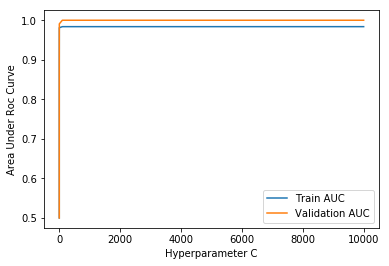

In [72]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.954


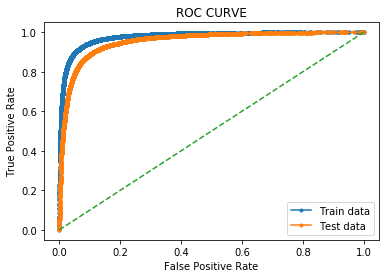

In [74]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l1',C=1)
clf.fit(Xtrain_bbw,Y_train)
# predict probabilities
probs = clf.predict_proba(Xtest_bbw)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(Xtrain_bbw)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [75]:
 c= [10**4, 10**2, 10**0, 10**-2, 10**-4]

for i in c:
    clf = LogisticRegression( penalty='l1',C=i)
    clf.fit(Xtrain_bbw,Y_train)
    pred=clf.predict(Xtest_bbw)
    w = clf.coef_
    print('\n')
    print("For lambda=%f" %(1/i))
    print("No of non zero elements=%d" %(np.count_nonzero(w)))
    print(np.count_nonzero(w))
    
    acc=accuracy_score(Y_test,pred)*100
    error=100-acc
    print("Error rate=%d" %error)
     



For lambda=0.000100
No of non zero elements=5000
5000
Error rate=11


For lambda=0.010000
No of non zero elements=4990
4990
Error rate=11


For lambda=1.000000
No of non zero elements=4112
4112
Error rate=10


For lambda=100.000000
No of non zero elements=220
220
Error rate=16


For lambda=10000.000000
No of non zero elements=1
1
Error rate=50


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [76]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l2',C=i)
    scores = cross_val_score(Log_R,Xtrain_bbw,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 1.000000 


In [77]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_bbw,Y_train)

print(model.best_estimator_)
print(model.score(Xtest_bbw, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9543804276636509


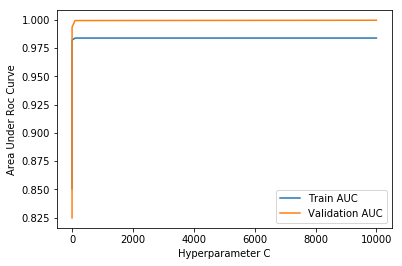

In [78]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.953


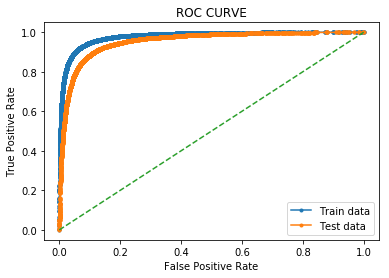

In [79]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l2',C=1)
clf.fit(Xtrain_bbw,Y_train)
# predict probabilities
probs = clf.predict_proba(Xtest_bbw)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(Xtrain_bbw)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [81]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l1',C=i)
    scores = cross_val_score(Log_R,Xtrain_tf,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 1.000000 


In [82]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_tf,Y_train)

print(model.best_estimator_)
print(model.score(Xtest_tf, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9622677535078524


In [83]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_tf, Y_train, test_size=0.3)

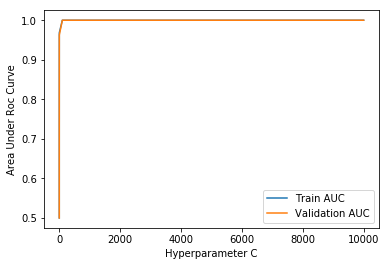

In [84]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.962


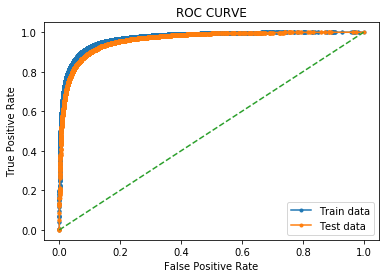

In [85]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l1',C=1)
clf.fit(Xtrain_tf,Y_train)
# predict probabilities
probs = clf.predict_proba(Xtest_tf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(Xtrain_tf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [86]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l2',C=i)
    scores = cross_val_score(Log_R,Xtrain_tf,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 1.000000 


In [87]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_tf,Y_train)

print(model.best_estimator_)
print(model.score(Xtest_tf, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9651435104596005


In [88]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_tf, Y_train, test_size=0.3)

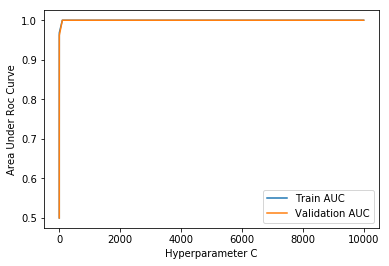

In [89]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.962


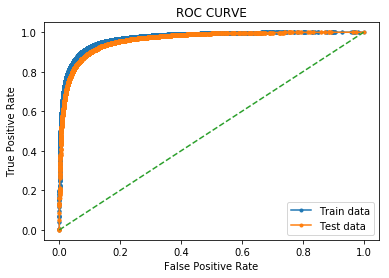

In [90]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l2',C=1)
clf.fit(Xtrain_tf,Y_train)
# predict probabilities
probs = clf.predict_proba(Xtest_tf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(Xtrain_tf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [54]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l1',C=i)
    scores = cross_val_score(Log_R,sent_trainvec,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 0.000100 


In [55]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(sent_trainvec,Y_train)

print(model.best_estimator_)
print(model.score(sent_testvec, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8433333333333334


In [91]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(sent_trainvec, Y_train, test_size=0.3)

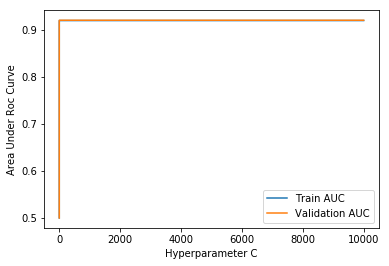

In [92]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.920


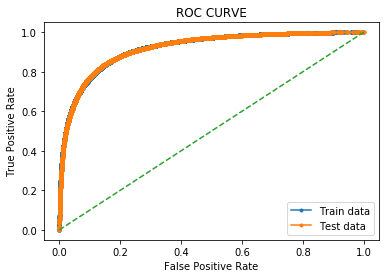

In [93]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l1',C=1)
clf.fit(sent_trainvec,Y_train)
# predict probabilities
probs = clf.predict_proba(sent_testvec)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(sent_trainvec)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [94]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l2',C=i)
    scores = cross_val_score(Log_R,sent_trainvec,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 1.000000 


In [95]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(sent_trainvec,Y_train)

print(model.best_estimator_)
print(model.score(sent_testvec, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.919628013064783


In [96]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(sent_trainvec, Y_train, test_size=0.3)

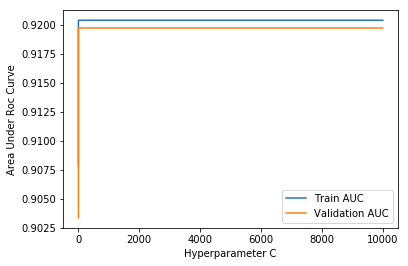

In [97]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.920


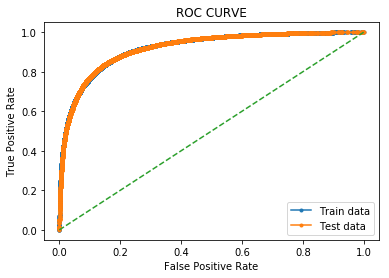

In [98]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l2',C=1)
clf.fit(sent_trainvec,Y_train)
# predict probabilities
probs = clf.predict_proba(sent_testvec)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(sent_trainvec)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [109]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l1',C=i)
    scores = cross_val_score(Log_R,tfw2v_train,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 100.000000 


In [100]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfw2v_train,Y_train)

print(model.best_estimator_)
print(model.score(tfw2v_test, Y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8966061168677946


In [101]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(tfw2v_train, Y_train, test_size=0.3)

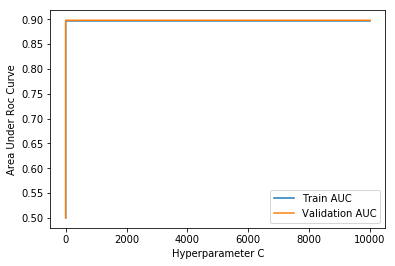

In [102]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.897


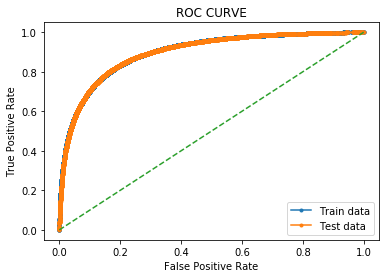

In [103]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l1',C=100)
clf.fit(tfw2v_train,Y_train)
# predict probabilities
probs = clf.predict_proba(tfw2v_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(tfw2v_train)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:
c=[10**-4, 10**-2, 10**0, 10**2, 10**4]
cv_scores = []
for i in c:
    Log_R = LogisticRegression(penalty='l2',C=i)
    scores = cross_val_score(Log_R,tfw2v_train,Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
    

MAUC = [ x for x in cv_scores]
optimal_c= c[MAUC.index(max(MAUC))]
print('\nThe optimal C is %f ' % optimal_c)


The optimal C is 1.000000 


In [105]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfw2v_train,Y_train)

print(model.best_estimator_)
print(model.score(tfw2v_test, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8966057657437606


In [106]:
#split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(tfw2v_train, Y_train, test_size=0.3)

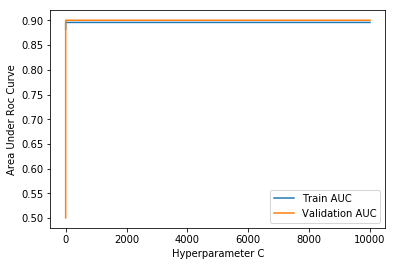

In [107]:
#performance plot
from sklearn.metrics import roc_auc_score

c=[10**-4, 10**-2, 10**0, 10**2, 10**4]

auc_train=[]
auc_val=[]
for item in c:
    clf = LogisticRegression(penalty='l2',C=item)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for item in c:
    clf = LogisticRegression(penalty='l1',C=item)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))


# plot misclassification error vs k 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()



AUC: 0.897


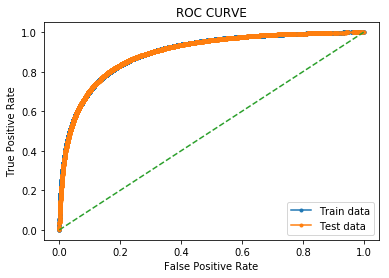

In [108]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import roc_curve

clf = LogisticRegression(penalty='l2',C=1)
clf.fit(tfw2v_train,Y_train)
# predict probabilities
probs = clf.predict_proba(tfw2v_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(tfw2v_train)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


# [6] Conclusions

In [1]:
#CREATING PRETTYTABLE
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "L1/L2 ","Hyperparameter", "AUC"]

x.add_row(["BOW","L1",1,0.954])
x.add_row(["BOW","L2",1,0.953])
x.add_row(["TFIDF","L1",1,0.962])
x.add_row(["TFIDF","L2",1,0.962])
x.add_row(["Word2Vec","L1",1,0.920])
x.add_row(["Word2Vec","L2",1,0.920])
x.add_row(["TFIDF-W2V","L1",100,0.897])
x.add_row(["TFIDF-W2V","L2",1,0.897])
print(x)

+------------+--------+----------------+-------+
| Vectorizer | L1/L2  | Hyperparameter |  AUC  |
+------------+--------+----------------+-------+
|    BOW     |   L1   |       1        | 0.954 |
|    BOW     |   L2   |       1        | 0.953 |
|   TFIDF    |   L1   |       1        | 0.962 |
|   TFIDF    |   L2   |       1        | 0.962 |
|  Word2Vec  |   L1   |       1        |  0.92 |
|  Word2Vec  |   L2   |       1        |  0.92 |
| TFIDF-W2V  |   L1   |      100       | 0.897 |
| TFIDF-W2V  |   L2   |       1        | 0.897 |
+------------+--------+----------------+-------+
